# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
%pip install --user labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations split-folders imutils scikit-learn keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Harry Parker\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import os
import cv2

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import Tensorflow and Dependences

In [4]:
import json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

### 2.2 Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('data\\img\\img\\*.jpg')

train_images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg')
test_images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg')
val_images = tf.data.Dataset.list_files('data\\val\\images\\*.jpg')

train_images.as_numpy_iterator().next()
test_images.as_numpy_iterator().next()
val_images.as_numpy_iterator().next()

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [10]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

train_images = train_images.map(load_image)
test_images = test_images.map(load_image)
val_images = val_images.map(load_image)

train_images.as_numpy_iterator().next()
test_images.as_numpy_iterator().next()
val_images.as_numpy_iterator().next()

type(train_images)
type(test_images)
type(val_images)

### 2.4 View Raw Images with Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = next(image_generator)

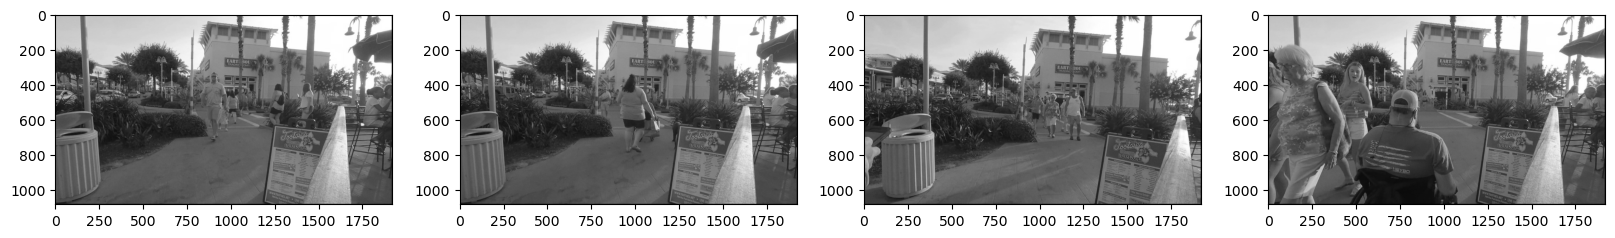

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

train_image_generator = train_images.batch(4).as_numpy_iterator()
test_image_generator = test_images.batch(4).as_numpy_iterator()
val_image_generator = val_images.batch(4).as_numpy_iterator()

plot_train_images = train_image_generator.next()
plot_test_images = test_image_generator.next()
plot_val_images = val_image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_train_images):
    ax[idx].imshow(image) 
plt.show()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_test_images):
    ax[idx].imshow(image) 
plt.show()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_val_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unargumented Data

### 3.1 Split data into training and testing and valid data

In [ ]:
import splitfolders
splitfolders.ratio('./data/img', output="./data/ttvimg", seed=1337, ratio=(.8, 0.1,0.1))

### 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Setup Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [14]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=1280, height=720)], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
testImage = cv2.imread(os.path.join('data','train','images','1.jpg'))

In [ ]:
with open(os.path.join('data', 'train', 'labels', '1.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][1]['points']

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][1]['points'][0][0]
coords[1] = label['shapes'][1]['points'][0][1]
coords[2] = label['shapes'][1]['points'][1][0]
coords[3] = label['shapes'][1]['points'][1][1]

In [ ]:
coords

In [ ]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [ ]:
coords

### 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=testImage, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1280, 720]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1280, 720]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('augmented-data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('augmented-data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [15]:
train_images = tf.data.Dataset.list_files('augmented-data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [16]:
test_images = tf.data.Dataset.list_files('augmented-data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [17]:
val_images = tf.data.Dataset.list_files('augmented-data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

# 5. Prepare Labels

### 5.1 Build Label Loading Function

In [19]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 5.2 Load Labels to Tensorflow Dataset

In [20]:
train_labels = tf.data.Dataset.list_files('augmented-data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
test_labels = tf.data.Dataset.list_files('augmented-data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
val_labels = tf.data.Dataset.list_files('augmented-data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [23]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 6. Combine Labels and Image Samples

### 6.1 Check Partition Length

In [24]:
len(train_images), len(test_images), len(val_images), len(train_labels), len(test_labels), len(val_labels)

(11640, 4380, 4560, 11640, 4380, 4560)

### 6.2 Final Datasets (Images/Labels)

In [25]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(11640)
train = train.batch(48)
train = train.prefetch(24)

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(4380)
test = test.batch(12)
test = test.prefetch(6)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(4560)
val = val.batch(16)
val = val.prefetch(8)

In [28]:
train.as_numpy_iterator().next()

(array([[[[0.1111111 , 0.1111111 , 0.1111111 ],
          [0.18333334, 0.18333334, 0.18333334],
          [0.3369281 , 0.3369281 , 0.3369281 ],
          ...,
          [0.2522868 , 0.2522868 , 0.2522868 ],
          [0.28039217, 0.28039217, 0.28039217],
          [0.3039235 , 0.3039235 , 0.3039235 ]],
 
         [[0.15065359, 0.15065359, 0.15065359],
          [0.21372549, 0.21372549, 0.21372549],
          [0.3738562 , 0.3738562 , 0.3738562 ],
          ...,
          [0.2993461 , 0.2993461 , 0.2993461 ],
          [0.31862745, 0.31862745, 0.31862745],
          [0.408172  , 0.408172  , 0.408172  ]],
 
         [[0.11307189, 0.11307189, 0.11307189],
          [0.14607844, 0.14607844, 0.14607844],
          [0.25751635, 0.25751635, 0.25751635],
          ...,
          [0.24509756, 0.24509756, 0.24509756],
          [0.25588235, 0.25588235, 0.25588235],
          [0.28693035, 0.28693035, 0.28693035]],
 
         ...,
 
         [[0.31209147, 0.31209147, 0.31209147],
          [0.29901

### 6.3 View Images and Annotations

In [29]:
data_samples = train.as_numpy_iterator()

In [30]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


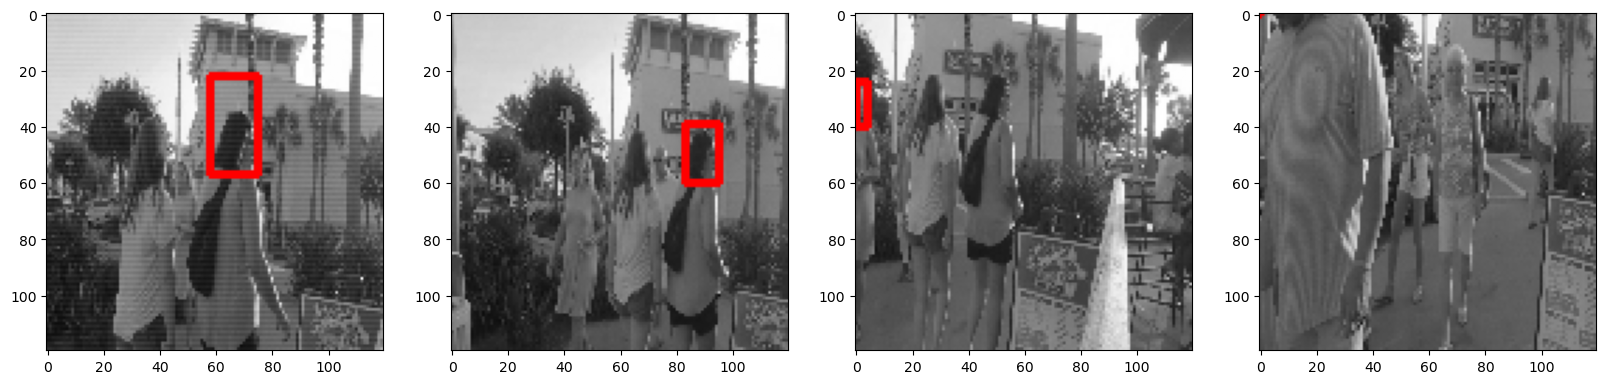

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 7 Build Deep Learning Model using the Functional API

### 8.1 Import Layers and Base Network

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 7.2 Download VGG16

In [33]:
vgg = VGG16(include_top=False)

In [34]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 7.3 Build Instance of Network

In [35]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facedetector = Model(inputs=input_layer, outputs=[class2, regress2])
    return facedetector

### 7.4 Test out Neural Network

In [36]:
facedetector = build_model()

In [37]:
facedetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [38]:
X, y = train.as_numpy_iterator().next()

In [39]:
X.shape

(48, 120, 120, 3)

In [40]:
classes, coords = facedetector.predict(X)

2/2 [==============================] - 2s 440ms/step


In [ ]:
classes, coords

# 8 Define Losses and Optimisers

### 8.1 Define Optimiser and LR

In [42]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 8.2 Create Localisation Loss and Classification Loss

In [44]:
def localisation_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [45]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localisation_loss

### 7.3 Test out Loss Metrics

In [46]:
localisation_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=13.91673>

In [47]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7000367>

In [48]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=13.91673>

# 8 Train Neural Network

### 9.1 Create Custom Model Class

In [49]:
class FaceTracker(Model):
    def __init__(self, facecctv, **kwargs):
        super().__init__(**kwargs)
        self.model = facecctv

    def compile(self, classloss, localisation_loss, opt, **kwargs):
        super().compile(**kwargs)
        self.clsloss = classloss
        self.localloss = localisation_loss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_class_loss = self.clsloss(y[0], classes)
            batch_localisation_loss = self.localloss(tf.cast(y[1], tf.float32), coords)

            total_loss = (0.5*batch_class_loss) + batch_localisation_loss

            gradient = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(gradient, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_localisation_loss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_class_loss = self.clsloss(y[0], classes)
        batch_localisation_loss = self.localloss(tf.cast(y[1], tf.float32), coords)
        total_loss = (0.5*batch_class_loss) + batch_localisation_loss

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_localisation_loss}

    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [50]:
model = FaceTracker(facedetector)

In [54]:
model.compile(classloss, localisation_loss, opt)

### 9.2 Train

In [51]:
logdir='logs'

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [55]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


### 9.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 10. Make Predictions

### 10.1 Make Predictions 

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facedetector.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 10.2 Save the Model

In [6]:
from keras.models import load_model

In [ ]:
facedetector.save('facecctv.h5')

# 12 Testing

### 12.1 Loading Models

In [7]:
facedetector = load_model('./models/facetracker.h5')
facecctv = load_model('facecctv.h5')

### 12.2 Testing face detection using webcam live

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (240,240))
    
    yhat = facecctv.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [1280, 720]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [1280, 720]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 120ms/step


### 12.3 Testing using dataset static images

In [ ]:
image = cv2.imread('data\\footage\\0.jpg')
plt.imshow(image)

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (240, 240))

yhat = facecctv.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]

if yhat[0] > 0.5: 
    # Controls the main rectangle
    cv2.rectangle(image, 
                    tuple(np.multiply(sample_coords[:2], [1280, 720]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [1280, 720]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(image, 
                    tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int), 
                                [0,-30])),
                    tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)
    
    # Controls the text rendered
    cv2.putText(image, 'face', tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                            [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

cv2.imshow('FaceCCTV', image)